In [8]:
from __future__ import absolute_import, division, print_function

# Full workflow - only to create the KDE map of the complete data base


# Imports

In [9]:
import copy
import glob
import json
import os
import pickle
import random
import re
import sys
import time
from collections import Counter

import googlemaps
import matplotlib as mpl
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import requests
import scipy.stats as ss
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline



# Data

In [10]:
# Get CA coordinates
try:
    x_coords
    y_coords
except:
    infile = os.path.join('..','..','data','ca_shape.csv')
    ca_shape = pd.read_csv(infile)
    x_coords = ca_shape['longitude'].tolist()
    y_coords = ca_shape['latitude'].tolist()



In [11]:
# import cleaned and pickled dataframe
try:
    flickr_all_clean.shape
except:
    start_time = time.time()
    flickr_all_clean = pd.read_pickle(os.path.join('..','..','data','flickr_all_clean.df'))
    print("--- %s seconds ---" % (time.time() - start_time))



In [12]:
df = flickr_all_clean

# Run KDE

In [13]:
# Select subset based on keyword
start_time = time.time()
# Set coordinates for cutout
limit_lng = [-122.7,-121.8]
limit_lat = [36.9,38.3]
#
limit_lng = [-123.194178,-121.375941]
limit_lat = [36.911135,38.202246]
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
    xin = np.array((df['latitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
# build array
XY = np.vstack([yin.ravel(), xin.ravel()]).T
# Run KDE
lng_max = limit_lng[0]
lng_min = limit_lng[1]
lat_max = limit_lat[0]
lat_min = limit_lat[1]
# Set up the data grid for the contour plot
xgrid = np.linspace(lng_min,lng_max,100)
ygrid = np.linspace(lat_min,lat_max,100)
X, Y = np.meshgrid(xgrid, ygrid)
#
xy = np.vstack([Y.ravel(), X.ravel()]).T
#
Xtrain = np.vstack([xin,yin]).T
Xtrain *= np.pi / 180.  # Convert lat/long to radians
# 
band = 0.0003
kde = KernelDensity(bandwidth=band,algorithm='ball_tree',rtol=1e-4)
kde.fit(Xtrain)
# evaluate only on land
# Create path for CA 
bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)
patch_time = time.time()
land_mask = np.zeros(xy.shape[0], dtype=bool)
for idx,tmp_coords in enumerate(xy):
    land_mask[idx] = bbPath.contains_point((tmp_coords[1], tmp_coords[0]))
print("--- Masking: %s seconds ---" % (time.time() - patch_time))
#
xy *= np.pi / 180. # Convert lat/long to radians
xy = xy[land_mask]
Z = -9999 + np.zeros(land_mask.shape[0])
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)
land_mask_reshape = land_mask.reshape(X.shape)

--- Masking: 4.975949049 seconds ---


# Plot map

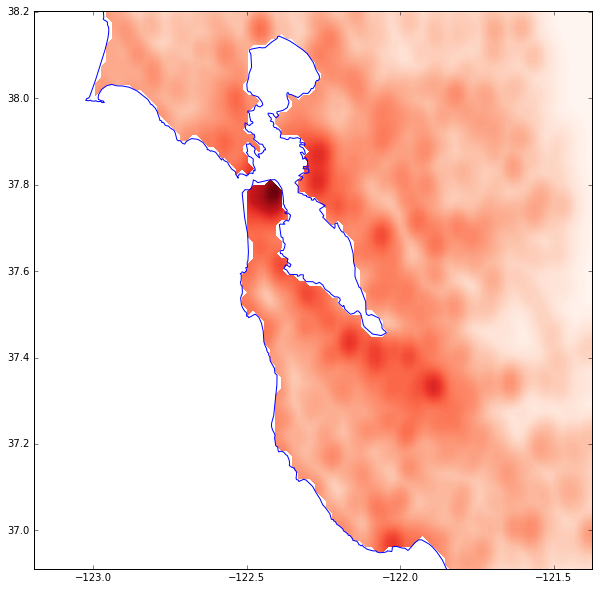

In [14]:
# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#  plot contours of the density
# Z_mask = Z < 29**2.*3
# Z_new = copy.copy(Z)
# Z_new = np.power(Z_new/np.nanmax(Z_new),1/4)
Z_new = np.power(Z/np.nanmax(Z),1/6)
levels = np.linspace(0,np.nanmax(Z_new), 150)
plt.contourf(X, Y, Z_new, levels=levels, cmap=plt.cm.Reds)
# plt.plot(xy_maxima_cut[:, 0], xy_maxima_cut[:, 1],'+', 
#          markersize=25,markeredgewidth=3,markeredgecolor='b')
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.7,38.5) 
#
# plt.title(keyword)
#
outname = os.path.join('img/kde_all.png')
plt.savefig(outname,bbox_inches='tight')

plt.show()

